In [9]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Flatten, Input
from keras.losses import BinaryCrossentropy

In [10]:
image_directory = "C:\\Users\\allan\\Downloads\\archive (2)\\bayc"
image_dimension = 128
noise_dimensions = 128

In [11]:
def create_dataset(directory_path):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory_path,
        labels=None,
        label_mode=None,
        class_names=None,
        color_mode='rgb',
        batch_size=32,
        image_size=(image_dimension, image_dimension),
        shuffle=True,
        seed=None,
        validation_split=None,
        subset=None,
        interpolation='bilinear',
        follow_links=False,
        crop_to_aspect_ratio=False
    )
    dataset = dataset.map(map_dataset)
    return dataset

def map_dataset(datapoint):
    return (datapoint-127.5)/127.5

def plot_image(image_tensor):
    image_tensor += 1
    image_tensor *= 0.5
    plt.imshow(image_tensor)
    plt.show()

In [12]:
dataset = create_dataset(image_directory)

Found 10000 files belonging to 1 classes.


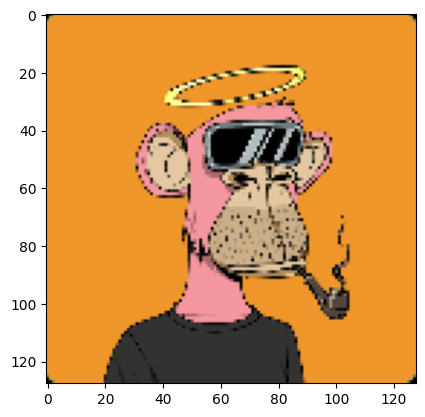

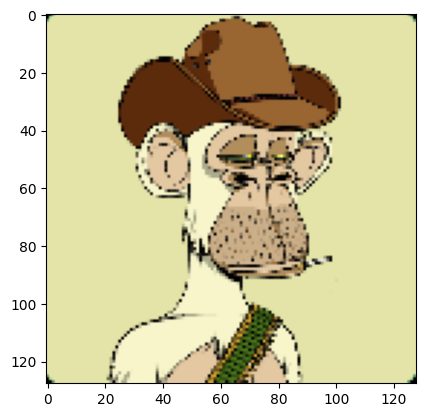

In [13]:
for batch in dataset.take(2):
    single_image = batch[0]
    plot_image(single_image)

In [14]:
#Build an auto encoder for the generator
first_layer_filters = 64
kernel_size = 4
autoencoder_generator = tf.keras.models.Sequential([

    #Encoding layers
    Input(shape=[noise_dimensions]),
    Dense(units = image_dimension*image_dimension*3),
    Reshape(target_shape=(image_dimension, image_dimension, 3)),
    Conv2D(filters = first_layer_filters, kernel_size=kernel_size, strides = 2,kernel_initializer='he_normal', use_bias=False, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(filters = first_layer_filters*2, kernel_size=kernel_size, strides = 2,kernel_initializer='he_normal', use_bias=False, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(filters = first_layer_filters*4, kernel_size=kernel_size, strides = 2,kernel_initializer='he_normal', use_bias=False, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(),

    #Bottleneck layer
    Conv2D(filters = first_layer_filters*8, kernel_size=kernel_size, strides = 2,kernel_initializer='he_normal', use_bias=False, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(),

    #Decoding layers
    Conv2DTranspose(filters = first_layer_filters*4, kernel_size=kernel_size, strides = 2, padding = 'same', activation='selu', use_bias=False),
    BatchNormalization(),
    Conv2DTranspose(filters = first_layer_filters*2, kernel_size=kernel_size, strides = 2, padding = 'same', activation='selu', use_bias=False),
    BatchNormalization(),
    Conv2DTranspose(filters = first_layer_filters, kernel_size=kernel_size, strides = 2, padding = 'same', activation='selu', use_bias=False),
    BatchNormalization(),
    Conv2DTranspose(filters = 3, kernel_size=kernel_size, strides = 2, padding = 'same', activation='tanh', use_bias=False),
])

In [15]:
#Build a normal encoder with a single output neuron as a discriminator
discriminator_filters = 64
kernel_size = 4
discriminator = tf.keras.models.Sequential([
    Input(shape = (image_dimension, image_dimension, 3)),
    Conv2D(filters = discriminator_filters, kernel_size = kernel_size, strides = 2, padding = 'same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(filters = discriminator_filters*2, kernel_size = kernel_size, strides = 2, padding = 'same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(filters = discriminator_filters*4, kernel_size = kernel_size, strides = 2, padding = 'same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(filters = discriminator_filters*8, kernel_size = kernel_size, strides = 2, padding = 'same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Flatten(),
    #Dense(units = 128, activation=LeakyReLU()),
    Dense(units = 1, activation='sigmoid')
])

In [16]:
#Define separate optimizers for the generator and discriminator
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [17]:
#Define a loss function. It just calculates loss, so one is enough for both models
loss_function = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

In [18]:
def train_the_model(dataset, epochs, noise_dimensions, GAN):
    generator, discriminator = GAN.layers
    for epochs in range(epochs):
        for batch in dataset:
            #Get the batch size
            batch_size = batch.shape[0]

            #PHASE 1 TRAIN THE DISCRIMINATOR
            #Create noise which will be the input to the generator
            noise = tf.random.normal(shape=[batch_size, noise_dimensions])
            #Pass the noise into the generator to get fake images
            fake_images = generator(noise)
            #Pass the fake images into the discriminator to get fake output (0s)
            fake_output = discriminator(fake_images)
            #Pass the real images from the batch into the discriminator to get real output (1s)
            real_output = discriminator(batch)
            #Create a tensor of 0s as labels for the fake output
            fake_labels = tf.constant(0, shape = (batch_size, 1))
            #Create a tensor of 1s as labels for the real output
            real_labels = tf.constant(0, shape = (batch_size, 1))
            #Calculate loss for fake outputs
            
            #Calculate loss for real outputs
            #Concatenate the fake and real losses
            #Concatenate the 2 label tensors
            #Calculate the gradient of the total loss with respect to the the model trainable variables
            #Apply the gradients to the model's trainable weights

            #PHASE 2 TRAIN THE GENERATOR
            #Create noise with the same dimensions as earlier
            #Pass the noise through the generator to create fake images
            #Create labels for these images (1s). We want to trick the discriminator
            #Pass the fake images through the discriminator to get the actual outputs
            #Calculate the loss using the loss function, between the created labels and the actual outputs
            #Calculate the gradient of the loss with respect to the generator's trainable variables. (RECHECK THIS ONE. SHOULD I CALCULATE THE GRADIENT FOR THE WHOLE NETWORK BY FREEZING THE DISCRIMINATOR)
            #Using the optimizer, apply the gradients to the generator's trainable weights
            pass
        #Calculate the time for each epoch
        pass
    pass

In [19]:
test = tf.constant(0, shape = (5, 1))
print(test)

tf.Tensor(
[[0]
 [0]
 [0]
 [0]
 [0]], shape=(5, 1), dtype=int32)


In [20]:
fake_output_discriminator_labels = [0 for x in range(5)]
fake_output_discriminator_labels = tf.reshape(fake_output_discriminator_labels, shape = (5, 1))
print(fake_output_discriminator_labels)

tf.Tensor(
[[0]
 [0]
 [0]
 [0]
 [0]], shape=(5, 1), dtype=int32)
